### 基于规则的模型：Persistence model
简单将前一天的值当作今天的预测

0.916 gene MAE

0.95 transplant MAE

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import *

random.seed(42)

读取数据

In [2]:
# (term_num, time_steps, feature_num)

gene_arr_path = r'../output/gene_editing/es_with_decay.array'
transplant_arr_path = r'../output/transplant/es_with_decay.array'

gene_arr = pickle.load(open(gene_arr_path, mode='rb'))
transplant_arr = pickle.load(open(transplant_arr_path, mode='rb'))

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 17, 10)
Shape of the transplant array: (5141, 17, 10)


### 截断数据
因2019年两个数据集的EmergingScore大部分都为0，而2018年及之前的情况要好很多，故抛弃2019年数据

In [3]:
gene_arr = gene_arr[:, :-1, :]
transplant_arr = transplant_arr[:, :-1, :]

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 16, 10)
Shape of the transplant array: (5141, 16, 10)


### 规范数据并获取训练集和测试集

In [4]:
# scaler, data = scale_data(gene_arr, 'none')
scaler, data = scale_data(transplant_arr, 'none')
X_train, X_test, y_train, y_test = split_data(data, n_input=11, ratio=0.2)

### 构建模型

In [5]:
def enhanced_persistence_model_predict(X, y):
    es_x = X[:, -1, -2].reshape(len(X), 1)
    es_y = y[:, :-1]
    return np.hstack((es_x, es_y))

def persistence_model_predict(X, y):
    timesteps = y.shape[1]
    result = np.zeros((X.shape[0], timesteps))
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i][j] = X[i, -1, -2]
    return result

预测

In [6]:
y_pred = persistence_model_predict(X_test, y_test).reshape(y_test.shape)

画图

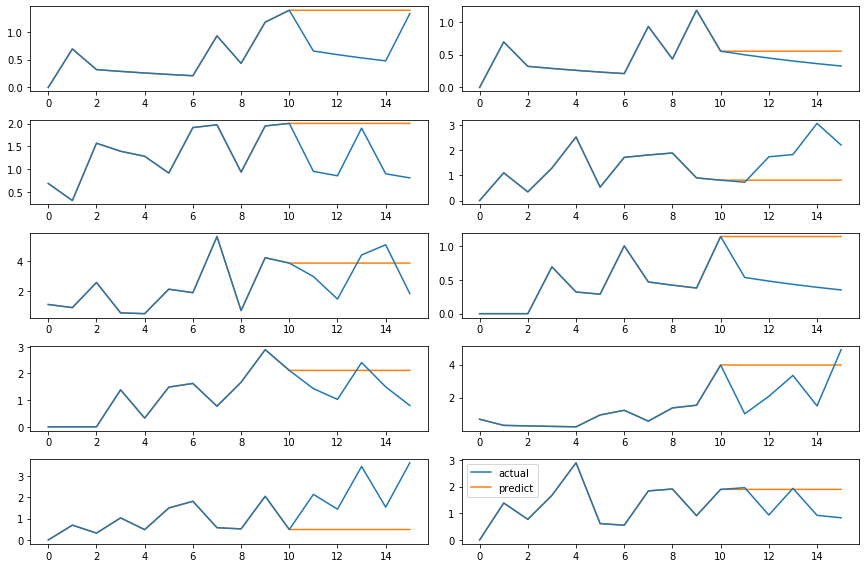

In [18]:
ids = random.sample(range(len(y_test)), 10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((X_test[ids[i], :, -2], y_test[ids[i]].reshape(-1)), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((X_test[ids[i], :, -2], y_pred[ids[i]].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

评估

MAE: 0.9285584215542914
MAE: [0.92636955 0.9292469  0.89988419 0.91980292 0.96748855]


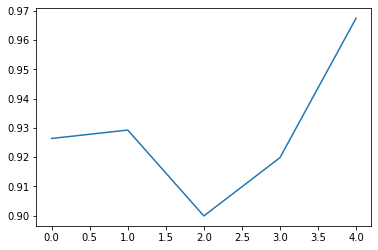

NDCG: 0.07639639816331842
NDCG: [0.02051769626916657, 0.00040708635870547507, 0.09197734055720286, 0.019698877564625416, 0.34334715757472256]


C:\Users\Tom Leung\OneDrive\文件\武汉大学\硕士投稿\主题热度预测\program\utils.py:36: RuntimeWarning: invalid value encountered in true_divide
  pred_score = np.sum((2 ** pred_array[:, 1] - 1) / np.log2(pred_array[:, 0] + 1))


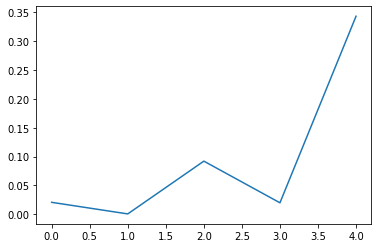

RMSE: 1.4977995402778925
RMSE: [1.52561503 1.53406954 1.46896838 1.48691317 1.4721983 ]


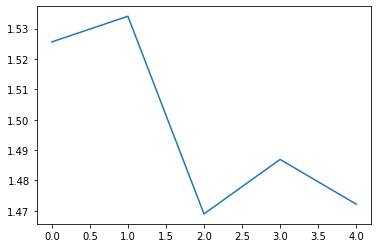

In [7]:
metrics = ['mae', 'ndcg', 'rmse']

for m in metrics:
    overall, annual = eval_model(m, y_test, y_pred, scaler)
    print('{}:'.format(m.upper()), overall)
    print('{}:'.format(m.upper()),annual)
    plt.plot(annual)
    plt.show()

In [14]:
_y_true, _y_pred = eval_model('classification', y_test, y_pred, scaler)

In [14]:
# 旧的，正常
from sklearn.metrics import classification_report
print(classification_report(_y_true.reshape(-1), _y_pred.reshape(-1)))

              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59        27
         1.0       0.69      0.67      0.68      3248
         2.0       0.18      0.18      0.18      1059
         3.0       0.40      0.34      0.37       548
         4.0       0.21      0.28      0.24       263

    accuracy                           0.52      5145
   macro avg       0.38      0.50      0.41      5145
weighted avg       0.53      0.52      0.52      5145



In [16]:
# 新的，不正常，因为按排位来划分会导致各个类别都相等
from sklearn.metrics import classification_report
print(classification_report(_y_true.reshape(-1), _y_pred.reshape(-1)))

              precision    recall  f1-score   support

         1.0       0.82      0.82      0.82      3600
         2.0       0.22      0.22      0.22       770
         3.0       0.27      0.27      0.27       515
         4.0       0.20      0.20      0.20       260

    accuracy                           0.64      5145
   macro avg       0.38      0.38      0.38      5145
weighted avg       0.64      0.64      0.64      5145

